In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'''
Class of 1-D radiative transfer model:
Input: 
    Tocean: initial ocean temperature Tocean 
    dt: time step
    layer: number of layers 
    Inshort: income shortwave radiation   
Function:
    readdata: get pressure, temperature, h2o, and co2 file, and calculate emissitivity of each layer
    forward: calculate temperature of next step
    record: append new temperature to previous ones
    model_plot: make a plot of temperature per step and final vertical temperature 
Wandi Yu
02.07.2017
'''
class r_t_model (object):
    def __init__(self, Tocean, dt = 60*60*24*10, layer = 40, Inshort = 240, O3absorb = 65):
        self.Tocean = Tocean
        self.Tatmo = np.zeros(layer)
        self.dt = dt
        self.Inshort = Inshort
        self.layer = layer
        self.p = np.linspace(1e5,0,layer+1)    
        self.O3absorb = O3absorb #total shortwave absorption of o3
        self.O3short = np.zeros(layer) #shortwave absorption of o3 on each layer
        self.ocndepth = 40    # average ocean mixing layer depth
        self.h2o = np.zeros(layer)
        self.co2 = np.zeros(layer)
        self.o3 = np.zeros(layer)
        self.Topatmorecord = []
        self.Toceanrecord = []
        self.sigma = 5.671e-8
        self.cpair = 1004
        self.cpocn = 4181
        self.rouwater = 1e3
        self.g = 9.8
        self.kh2o = 8e-3
        self.kco2 = 2.e-1
        self.ko3 = 1e-1
    def SAT(self,temp,pr):
#-------------calculate the saturation h2o mixing ratio---------------------------------
        h2o = np.exp(20.386-5132/temp)*133.32239/pr
        return h2o
    def calculatewater(self):
        h2o = np.zeros(self.layer)
        p_layer=(self.p[1:]+self.p[:-1])/2.
        Ptropopause = 10000.
        i_troposphere = (p_layer)>=Ptropopause
        h2o[i_troposphere] = 0.8*self.SAT(self.Tatmo[i_troposphere],p_layer[i_troposphere])
        h2o[(p_layer)<Ptropopause] = h2o[i_troposphere].min()
        return h2o
        
    def readdata (self): 
#----------function: read initial temperature field, and mixing ratio of h2o and co2----
        file1='/Users/wandi/604/rtmodel_wandiyu/42_newprofiles.txt'
        file_starter=2
        variable_starter=2
        variable_number=5
        Data = open(file1)
        read_data = Data.read().split('\n')
        data_length = 43
        pressure = np.zeros(data_length)
        temp = np.zeros(data_length)
        h2o = np.zeros(data_length)
        co2 = np.zeros(data_length)
        o3 = np.zeros(data_length)
        for i in range (data_length):
            pressure[i],temp[i],h2o[i],co2[i],o3[i]=read_data[i+file_starter].\
            split()[variable_starter:variable_number+variable_starter]  
        pressure = pressure*100          # convert from hPa to Pa
        p_layer=(self.p[1:]+self.p[:-1])/2.
        self.Tatmo = np.interp(p_layer,pressure,temp)
        #self.Tatmo = np.linspace(290,200,self.layer)    
        #self.h2o = np.interp(p_layer,pressure,h2o)
        Ptropopause = 10000.
        Pstratopause = 100.
        i_stratosphere = np.all([(p_layer)<Ptropopause,(p_layer)>=Pstratopause],axis=0)
        i_ionosphere = (p_layer)<Pstratopause
        self.co2 = np.interp(p_layer,pressure,co2)  
        self.o3 = np.interp(p_layer,pressure,o3)
        n = len(np.where(i_stratosphere)[0])
        self.O3short[i_stratosphere] = np.power(np.arange(n),2)/np.power(np.arange(n),2)\
                        .sum()*self.O3absorb
    def energybudget(self,k,mr,kw='None'):
#-----------get emissitivity----------------------------------------------------------
        Dp = self.p[:-1]-self.p[1:]
        opticaldepth = mr*k/self.g*Dp
        epsilon = 1-np.exp(-opticaldepth)
#---------Calculate the upward and downward emission of each layer--------------------
        # blackbody emission of ocean:
        Focean = self.sigma*(self.Tocean**4)
        # emission on each level: 
        Fatmo = self.sigma*(self.Tatmo**4)*epsilon
#---------calculate the amount of emission reaching each layer------------------------
        # define a levelA*levelB dimension variable to calculate the remaining emission 
        # on levelA from levelB
        Freach = np.zeros([self.layer,self.layer])
        # a variable calculating emission reaching sea surfact:
        Finocean = np.zeros(self.layer)
        Foutocean = np.zeros(self.layer)
        Finocean[0] = Fatmo[0]
        Foutocean[0] = Focean
        trans3=(1-epsilon[0]) #transmisivity of ocean flux path
        
        for i in range(self.layer-1):
            trans1=1 #upward transmisivity
            trans2=1 #downward transmisivity           
            Freach[i,i+1] = Fatmo[i]
            Freach[i+1,i] = Fatmo[i+1]
        # upward:
            for j in range(self.layer-i-2): 
                trans1 = trans1*(1-epsilon[i+j+1])
                Freach[i,i+j+2] = Fatmo[i]*trans1
        # downward    
            for k in range(i):
                trans2 = trans2*(1-epsilon[i-k])
                Freach[i+1,i-1-k] = Fatmo[i+1]*trans2
            Finocean[i+1] = Fatmo[i+1]*trans3
            Foutocean[i+1] = Focean*trans3
            trans3 = trans3*(1-epsilon[i+1])
#----------calculate total energy budget of each layer--------------------------------
        Ftotal_atmo = epsilon*(Freach.sum(axis=0)+Foutocean)-Fatmo*2
        if kw == 'o3':
            Ftotal_atmo = Ftotal_atmo+self.O3short
        Ftotal_inocn = Finocean.sum()
        return Ftotal_atmo,Ftotal_inocn        
    def forward (self):        
#----------calculate temperature of each layer and ocean------------------------------
        Focean = self.sigma*(self.Tocean**4)
        self.h2o = self.calculatewater()
        Ftotal_atmo_h2o,Ftotal_inocn_h2o = self.energybudget(self.kh2o,self.h2o)
        Ftotal_atmo_co2,Ftotal_inocn_co2 = self.energybudget(self.kco2,self.co2)
        Ftotal_atmo_o3,Ftotal_inocn_o3 = self.energybudget(self.ko3,self.o3,kw='o3')
        Ftotal_atmo = Ftotal_atmo_h2o+Ftotal_atmo_co2+Ftotal_atmo_o3
        Ftotal_ocn = self.Inshort-Focean+(Ftotal_inocn_h2o+Ftotal_inocn_co2+Ftotal_inocn_o3)
        Dp = self.p[:-1]-self.p[1:]
        DTatmo = self.dt*self.g/self.cpair*Ftotal_atmo/Dp
        DTocean = self.dt*Ftotal_ocn/self.rouwater/self.cpocn/self.ocndepth
        self.Tatmo=self.Tatmo+DTatmo
        self.Tocean=self.Tocean+DTocean
    def record(self):
#-----------record sea surface temperature and top of atmosphere temp of each time step---
        self.Toceanrecord = np.append(self.Toceanrecord,self.Tocean)
        self.Topatmorecord = np.append(self.Topatmorecord,self.Tatmo[-1]) 
    def model_plot(self):
        plt.figure(figsize=[14,5])
        plt.subplot(1,2,1)
        plt.plot(self.Toceanrecord,label='sea surface temperature')
        plt.plot(self.Topatmorecord,label='top of atmopsheric temperature')
        plt.xlabel('time step')
        plt.ylabel('temperature (K)')
        plt.legend(loc=0)
        plt.title('temperature at each time step')

        plt.subplot(1,2,2)
        plt.plot(self.Tatmo,(self.p[1:]+self.p[:-1])/200.)
        plt.gca().invert_yaxis()
        plt.xlabel('temperature (K)')
        plt.ylabel('Pressure(hPa)')
        plt.title('Final vertical temperature')   

288.741771358


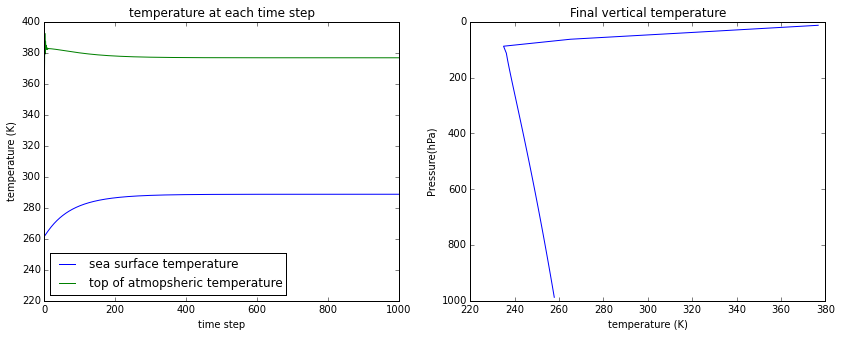

In [478]:
Tocean = 260
model=r_t_model(Tocean)
model.readdata()
model.record()
for i in range (1000):
    model.forward()
    model.record()
    if abs(model.Toceanrecord[-1]-model.Toceanrecord[-2]) < 1e-6:
        break
model.model_plot()
print (model.Tocean)

# sensitivity test: change initial sea surface temperature

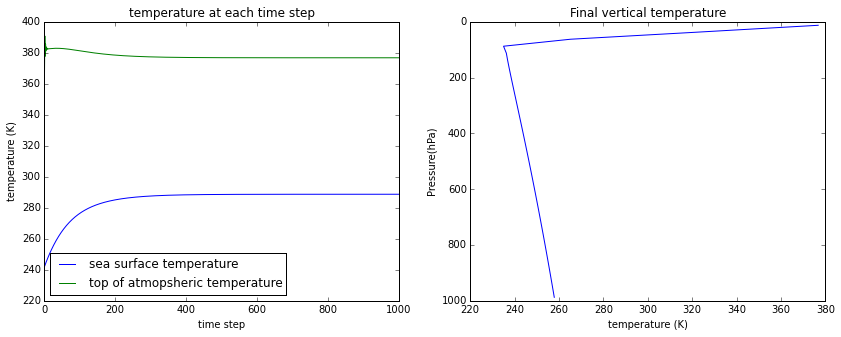

In [479]:
Tocean = 240
model=r_t_model(Tocean)
model.readdata()
model.record()
for i in range (1000):
    model.forward()
    model.record()
    if abs(model.Toceanrecord[-1]-model.Toceanrecord[-2]) < 1e-6:
        break
model.model_plot()

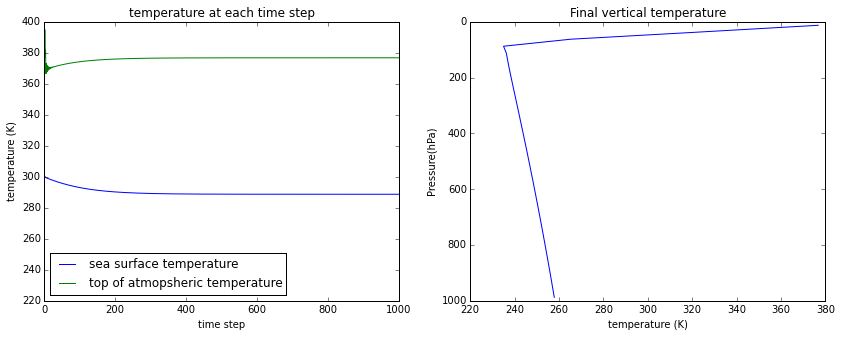

In [480]:
Tocean = 300
model=r_t_model(Tocean)
model.readdata()
model.record()
for i in range (1000):
    model.forward()
    model.record()
    if abs(model.Toceanrecord[-1]-model.Toceanrecord[-2]) < 1e-6:
        break
model.model_plot()

# sensitivity test: change time step

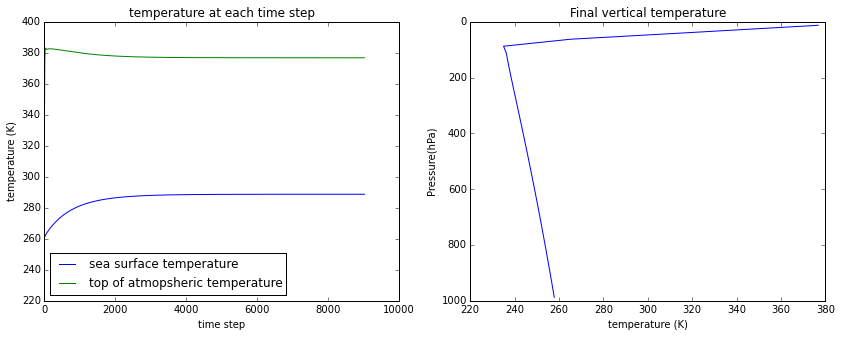

In [481]:
Tocean = 260
timestep = 60*60*24
model=r_t_model(Tocean,dt = timestep)
model.readdata()
model.record()
for i in range (10000):
    model.forward()
    model.record()
    if model.Toceanrecord[-1]-model.Toceanrecord[-2] < 1e-6:
        break
model.model_plot()

# sensitivity test: change number of layers

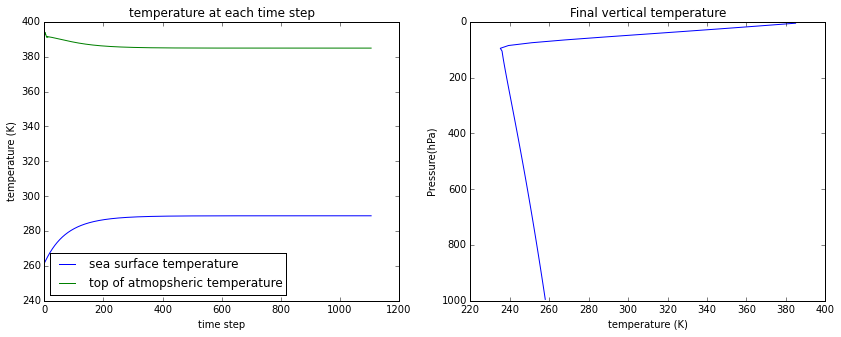

In [482]:
Tocean = 260
model=r_t_model(Tocean,dt = 60*60*24*10,layer = 100)
model.readdata()
model.record()
for i in range (10000):
    model.forward()
    model.record()
    if abs(model.Toceanrecord[-1]-model.Toceanrecord[-2]) < 1e-6:
        break
model.model_plot()

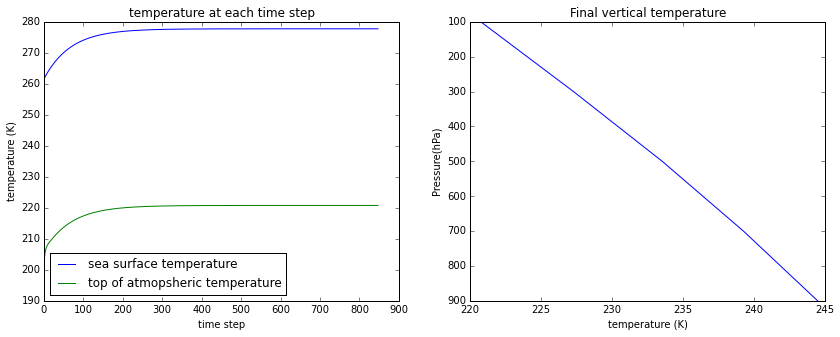

In [483]:
Tocean = 260
model=r_t_model(Tocean,dt = 60*60*24*10,layer = 5)
model.readdata()
model.record()
for i in range (10000):
    model.forward()
    model.record()
    if abs(model.Toceanrecord[-1]-model.Toceanrecord[-2]) < 1e-6:
        break
model.model_plot()